In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
infiles = {
    ('ACCESS-CM2', 'ssp245'): 'example_data/spei_mon_ACCESS-CM2_ssp245_ensemble_aus-states_1850-2100.csv',
    ('ACCESS-CM2', 'ssp370'): 'example_data/spei_mon_ACCESS-CM2_ssp370_ensemble_aus-states_1850-2100.csv',
    ('MPI-ESM1-2-LR', 'ssp245') : 'example_data/spei_mon_MPI-ESM1-2-LR_ssp245_ensemble_aus-states_1850-2100.csv',
    ('MPI-ESM1-2-LR', 'ssp370') : 'example_data/spei_mon_MPI-ESM1-2-LR_ssp370_ensemble_aus-states_1850-2100.csv',
}

In [8]:
df_dict = {}
df = pd.read_csv(infiles[('ACCESS-CM2', 'ssp245')])
df_dict[('ACCESS-CM2', 'ssp245')] = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()
df = pd.read_csv(infiles[('ACCESS-CM2', 'ssp370')])
df_dict[('ACCESS-CM2', 'ssp370')] = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()

df = pd.read_csv(infiles[('MPI-ESM1-2-LR', 'ssp245')])
df_dict[('MPI-ESM1-2-LR', 'ssp245')] = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()
df = pd.read_csv(infiles[('MPI-ESM1-2-LR', 'ssp370')])
df_dict[('MPI-ESM1-2-LR', 'ssp370')] = df.drop(['month', 'model', 'experiment'], axis=1).groupby(['year', 'run']).mean().reset_index()

In [9]:
df_dict[('ACCESS-CM2', 'ssp370')]

,year,run,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
0,1850,r10i1p1f1,-0.980000,-0.250000,-0.410000,0.420000,0.980000,-0.830000,-0.150000,0.140000
1,1850,r1i1p1f1,-0.910000,-0.170000,-1.240000,-0.150000,-0.420000,0.280000,-0.260000,-0.580000
2,1850,r2i1p1f1,-0.920000,-0.170000,-0.750000,-0.880000,-1.170000,0.200000,-0.790000,-0.900000
3,1850,r3i1p1f1,-0.760000,-0.390000,-1.250000,-0.020000,0.660000,-0.220000,-0.800000,-0.300000
4,1850,r4i1p1f1,-0.700000,-0.480000,-0.060000,-0.530000,-0.450000,-0.460000,-0.380000,-0.390000
...,...,...,...,...,...,...,...,...,...,...
2505,2100,r5i1p1f1,-2.308333,-2.741667,-3.015000,-4.863333,-3.941667,-2.088333,-3.576667,-3.565833
2506,2100,r6i1p1f1,0.483333,-0.690833,-0.556667,-1.196667,-1.647500,-0.676667,-1.370000,-1.037500
2507,2100,r7i1p1f1,-0.825000,-2.004167,-2.439167,-2.998333,-1.606667,-2.459167,-1.925000,-1.965833
2508,2100,r8i1p1f1,-0.662500,-2.244167,-0.170833,-2.376667,-2.638333,-0.564167,-0.454167,-1.430833


In [10]:
def plot_location(model, experiment, location, start_year=1950):
    """Scatterplot for a given location"""

    df = df_dict[(model, experiment)]
    fig, ax = plt.subplots(figsize=[15,7])
    sns.scatterplot(
        ax=ax,
        data=df[df['year'] >= start_year],
        x='year',
        y=location,
        hue='run',
    )
    ax.set_ylabel('SPEI')
    ax.set_title(f'{model} - {location}')
    ax.grid()
    plt.show()

In [16]:
def plot_dist(model, experiment, location, start_year=1950, end_year=2014):
    """Histogram for a given location"""

    df = df_dict[(model, experiment)]
    df_ref = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    fig, ax = plt.subplots()
    sns.histplot(
        ax=ax,
        data=df_ref,
        x=location,
    )
    ax.set_ylabel('SPEI')
    ax.set_title(f'{model} - {experiment} - {location}')
    ax.grid()
    plt.show()

In [12]:
def plot_model_odds(
    model,
    experiment,
    location,
    ref_start=1950,
    ref_end=2014,
    runs_subsets=[],
):
    """Odds of a year lower than a given quantile for a given location."""

    fig, ax = plt.subplots()
    
    df = df_dict[(model, experiment)]
    runs_list = df['run'].unique()
    iter_runs = runs_subsets + [len(runs_list),]
    for nruns in iter_runs:
        runs = runs_list[0:nruns]
        df = df_dict[(model, experiment)]
        df = df[df['run'].isin(runs)]
        df_ref = df[(df['year'] >= ref_start) & (df['year'] <= ref_end)]
        p02 = df_ref[location].quantile(0.02)
        print(f'2nd percentile = {p02} ({ref_start}-{ref_end}; {nruns} runs)') 
        window = nruns * 20
        odds = df[location].rolling(window, step=nruns, center=True).apply(lambda s: (sum(s < p02) / window) * 100)
        odds.index = df['year'].unique()
        odds = odds.dropna()
        sns.lineplot(
            ax=ax,
            data=odds,
            label=f'{nruns} runs',
        )
    ax.set_xlabel('year')
    ax.set_ylabel('odds of exceeding 1-in-50 year event (%)') 
    ax.set_title(f'SPEI - {model} - {experiment} - {location}')
    ax.grid()
    plt.show()

In [24]:
colors = {
    'ssp126': 'tab:blue',
    'ssp245': 'tab:green',
    'ssp370': 'tab:orange',
    'ssp585': 'tab:red',
}

linestyles = {
    'ACCESS-CM2': '-',
    'MPI-ESM1-2-LR': ':',
}


def plot_ensemble_odds(
    location,
    ref_start=1950,
    ref_end=2014,
):
    """Ensemble odds of a year higher than a given quantile for a given location."""

    fig, ax = plt.subplots()
    for key, df in df_dict.items():
        model, experiment = key
        df_ref = df[(df['year'] >= ref_start) & (df['year'] <= ref_end)]
        p02 = df_ref[location].quantile(0.02)
        print(f'2nd percentile = {p02} ({ref_start}-{ref_end}; {model})')
        nruns = len(df['run'].unique())
        window = nruns * 20
        odds = df[location].rolling(window, step=nruns, center=True).apply(lambda s: (sum(s < p02) / window) * 100)
        odds.index = df['year'].unique()
        odds = odds.dropna()
        sns.lineplot(
            ax=ax,
            data=odds,
            label=f'{model} ({experiment})',
            color=colors[experiment],
            linestyle=linestyles[model],
        )
    ax.set_xlabel('year')
    ax.set_ylabel('odds of exceeding 1-in-50 year event (%)') 
    ax.set_title(f'SPEI - {location}')
    ax.grid()
    plt.show()

## ACCESS-CM2

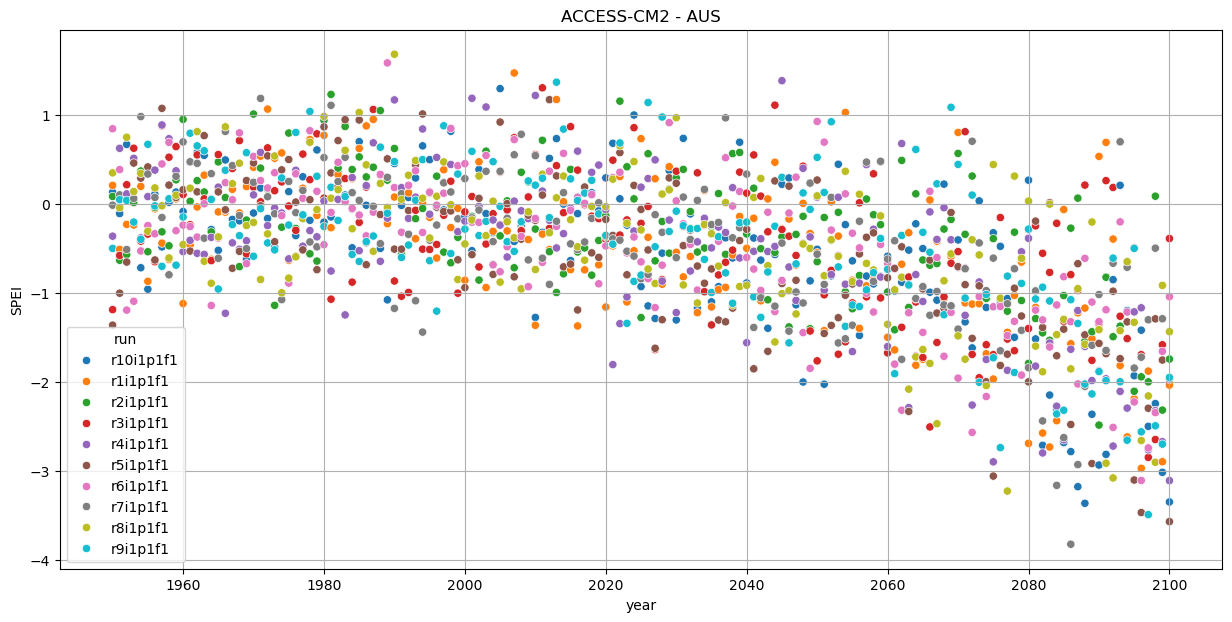

In [14]:
plot_location('ACCESS-CM2', 'ssp370', 'AUS')

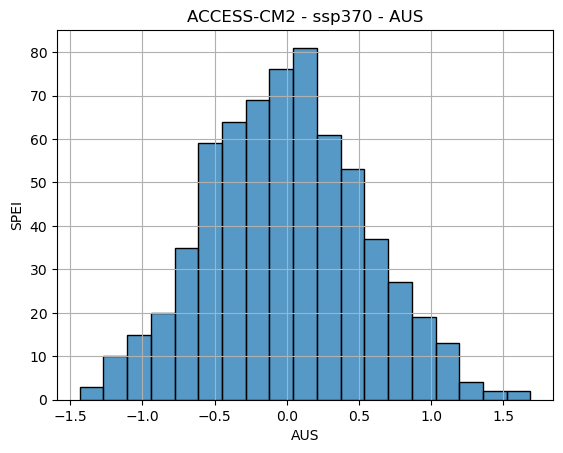

In [17]:
plot_dist('ACCESS-CM2', 'ssp370', 'AUS')

2nd percentile = -1.0397333333333332 (1950-2014; 1 runs)
2nd percentile = -1.0896833333333333 (1950-2014; 10 runs)


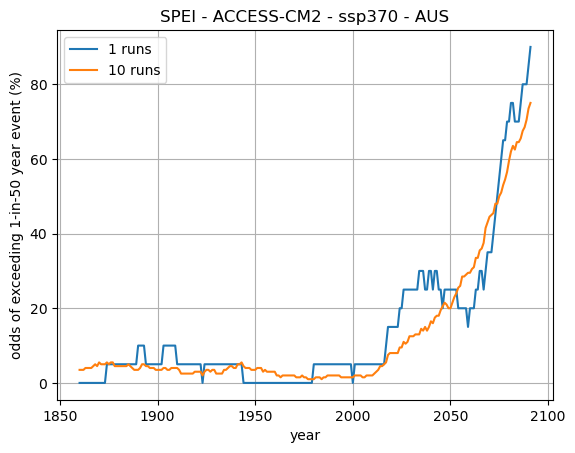

In [18]:
plot_model_odds('ACCESS-CM2', 'ssp370', 'AUS', runs_subsets=[1,])

2nd percentile = -1.0397333333333332 (1950-2014; 1 runs)
2nd percentile = -1.0908333333333333 (1950-2014; 2 runs)
2nd percentile = -1.095 (1950-2014; 5 runs)
2nd percentile = -1.0896833333333333 (1950-2014; 10 runs)


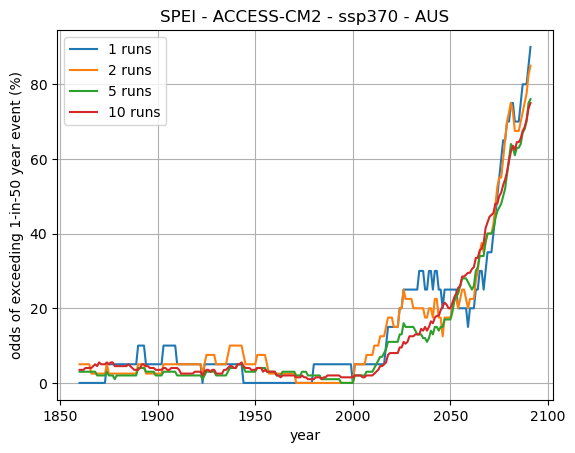

In [19]:
plot_model_odds('ACCESS-CM2', 'ssp370', 'AUS', runs_subsets=[1,2,5])

## MPI-ESM1-2-LR

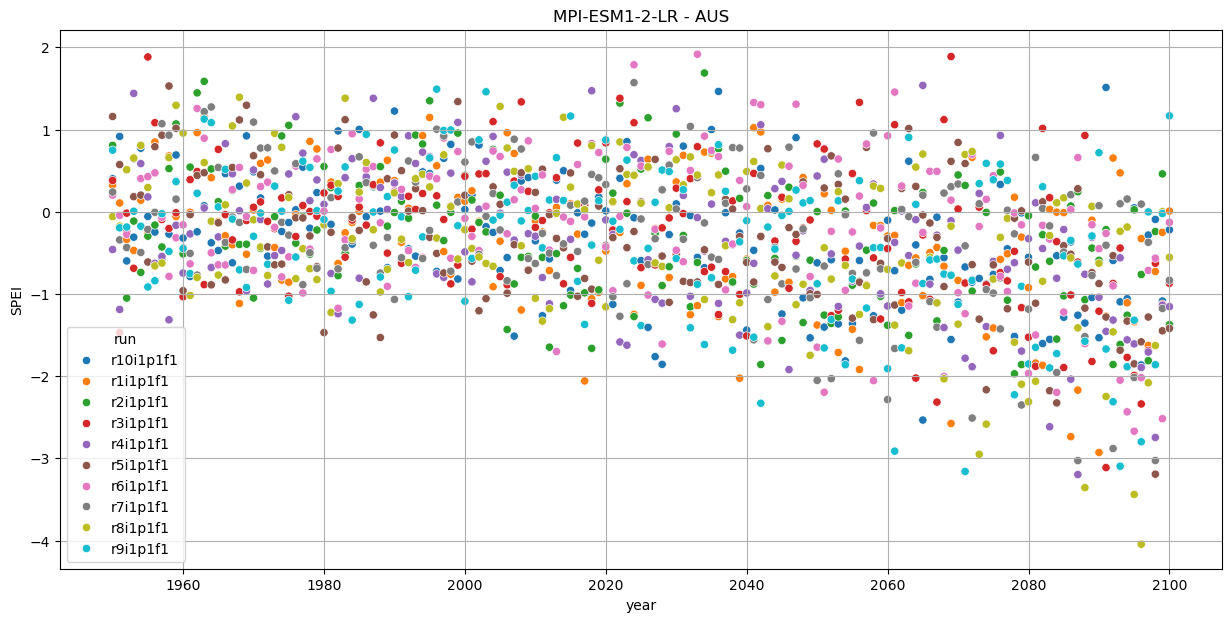

In [20]:
plot_location('MPI-ESM1-2-LR', 'ssp370', 'AUS')

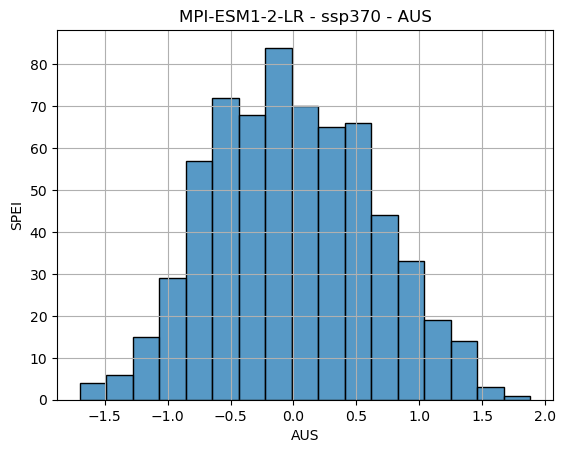

In [21]:
plot_dist('MPI-ESM1-2-LR', 'ssp370', 'AUS')

2nd percentile = -1.1399333333333332 (1950-2014; 1 runs)
2nd percentile = -1.2253166666666666 (1950-2014; 10 runs)


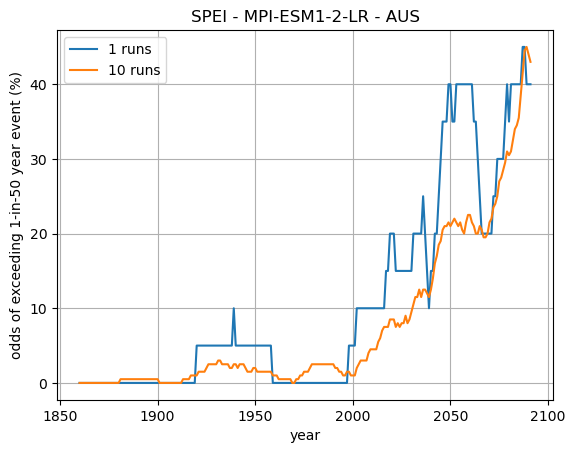

In [17]:
plot_model_odds('MPI-ESM1-2-LR', 'AUS', runs_subsets=[1,])

2nd percentile = -1.1399333333333332 (1950-2014; 1 runs)
2nd percentile = -1.1490833333333335 (1950-2014; 2 runs)
2nd percentile = -1.2188333333333334 (1950-2014; 5 runs)
2nd percentile = -1.2253166666666666 (1950-2014; 10 runs)


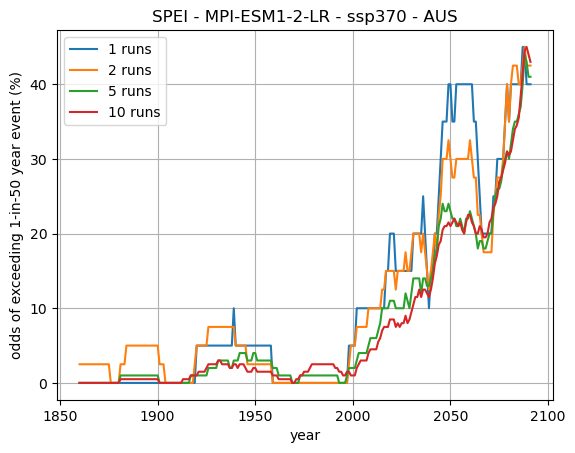

In [22]:
plot_model_odds('MPI-ESM1-2-LR', 'ssp370', 'AUS', runs_subsets=[1,2,5])

## Ensemble

2nd percentile = -1.0896833333333333 (1950-2014; ACCESS-CM2)
2nd percentile = -1.0896833333333333 (1950-2014; ACCESS-CM2)
2nd percentile = -1.2253166666666666 (1950-2014; MPI-ESM1-2-LR)
2nd percentile = -1.2253166666666666 (1950-2014; MPI-ESM1-2-LR)


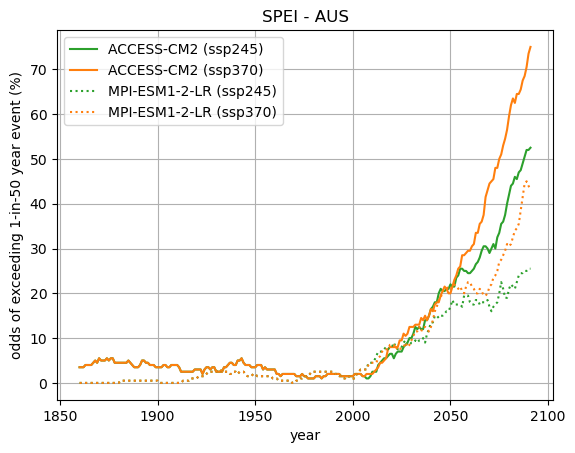

In [25]:
plot_ensemble_odds('AUS')

2nd percentile = -1.5135333333333334 (1950-2014; ACCESS-CM2)
2nd percentile = -1.5135333333333334 (1950-2014; ACCESS-CM2)
2nd percentile = -1.5509333333333333 (1950-2014; MPI-ESM1-2-LR)
2nd percentile = -1.5509333333333333 (1950-2014; MPI-ESM1-2-LR)


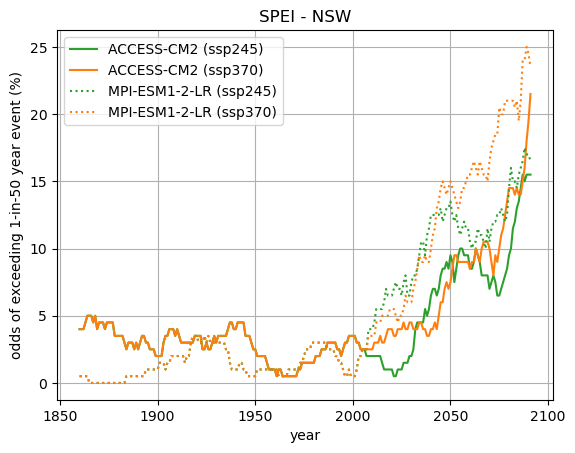

In [26]:
plot_ensemble_odds('NSW')

2nd percentile = -1.4422666666666666 (1950-2014; ACCESS-CM2)
2nd percentile = -1.4422666666666666 (1950-2014; ACCESS-CM2)
2nd percentile = -1.5146333333333335 (1950-2014; MPI-ESM1-2-LR)
2nd percentile = -1.5146333333333335 (1950-2014; MPI-ESM1-2-LR)


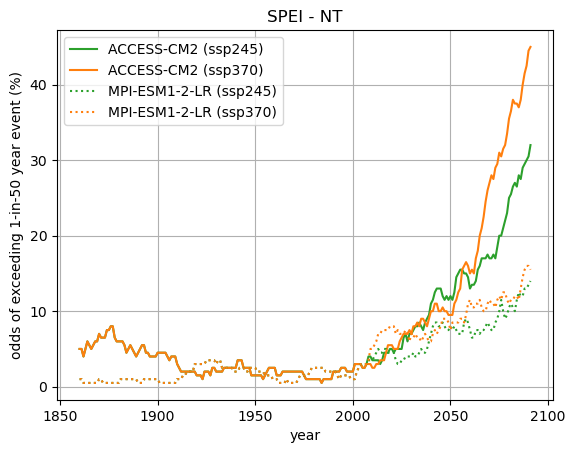

In [27]:
plot_ensemble_odds('NT')

2nd percentile = -1.46615 (1950-2014; ACCESS-CM2)
2nd percentile = -1.46615 (1950-2014; ACCESS-CM2)
2nd percentile = -1.5018333333333334 (1950-2014; MPI-ESM1-2-LR)
2nd percentile = -1.5018333333333334 (1950-2014; MPI-ESM1-2-LR)


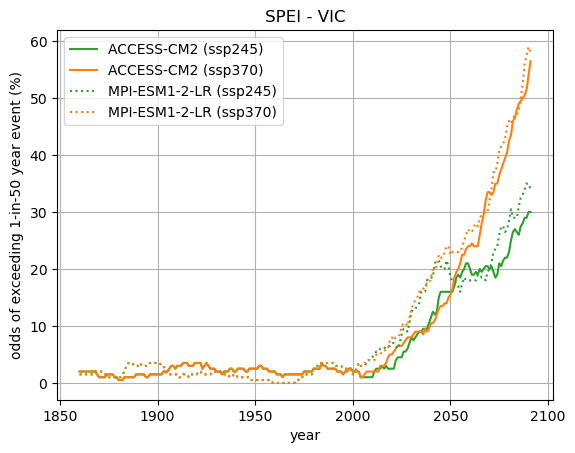

In [28]:
plot_ensemble_odds('VIC')